In [2]:
import numpy as np
import matplotlib.pylab as plt

In [3]:
#Use firn model from Arthern et al. for Greenland, Allison et al. for South Pole, 
#Kovacs et al. for conversion from density to index

#first define a few functions that will be useful.
def getDensity(thisDepth): #get density at a certain depth in feet
    thisDepth=thisDepth*0.3048 #convert feet to meters
    if southPoleFlag==0: #in Greenland
        if thisDepth <= 14.89:
            density=0.917-0.637*np.exp(-thisDepth/27)
        else:
            density=0.917-0.367*np.exp(-(thisDepth-14.89)/42)
    #n(z)=1.78-0.43e^(13.2z) z in km
    if southPoleFlag==1: #at South Pole
        nofz=1.78-0.43*np.exp(-thisDepth*0.0132)
        density=(nofz-1)/0.845
        #density=-thisDepth/200-200
    else: #try weird stuff in the model
        if thisDepth <= 14.89:
            density=0.917-0.637*np.exp(-thisDepth/27)
        else:
            density=0.917-0.367*np.exp(-(thisDepth-14.89)/75)
    return density

def getIndex(thisDensity): #get index of refraction given some density
    ePrime=(1+0.845*thisDensity)**2
    index=np.sqrt(ePrime)        
    return index

def refractRay(index1,index2,theta1): #do refraction across some boundary
    if (np.sin(theta1)*index1/index2 > 1):
        theta2=theta1
    else:
        theta2=np.arcsin(np.sin(theta1)*index1/index2)
    return theta2

****Trying Normal Ray Tracing...
Step size: 0.19024
0.0 45.0 90.0


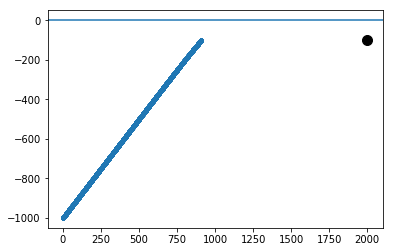

45.0 67.5 90.0


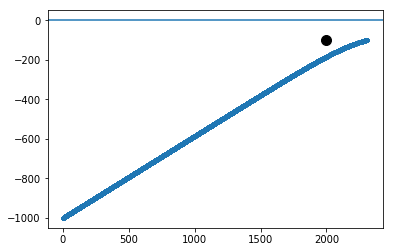

45.0 56.25 67.5


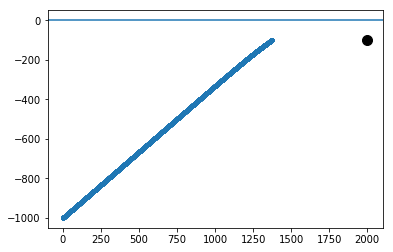

56.25 61.875 67.5


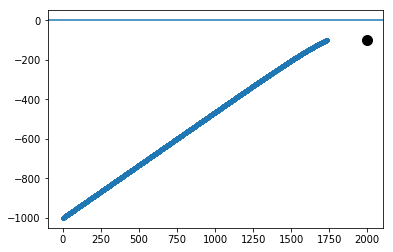

61.875 64.6875 67.5


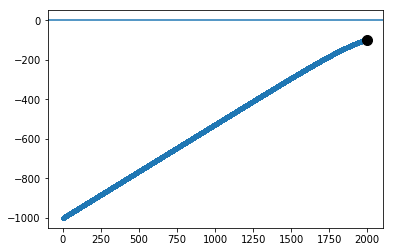

64.6875 66.09375 67.5


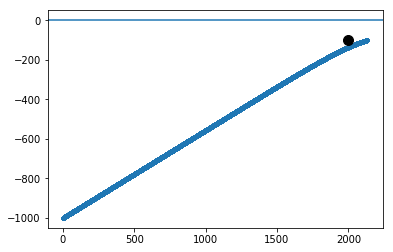

64.6875 65.390625 66.09375


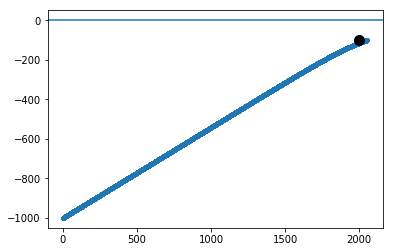

64.6875 65.0390625 65.390625


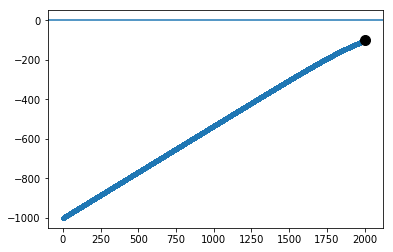

64.6875 64.86328125 65.0390625


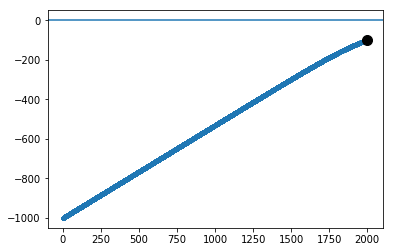

64.6875 64.775390625 64.86328125


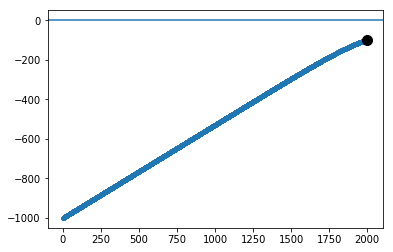

64.775390625 64.8193359375 64.86328125


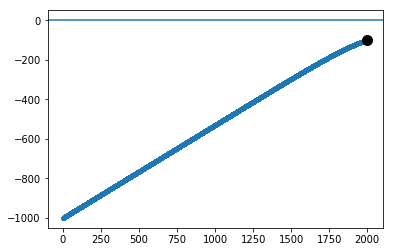

64.8193359375 64.84130859375 64.86328125


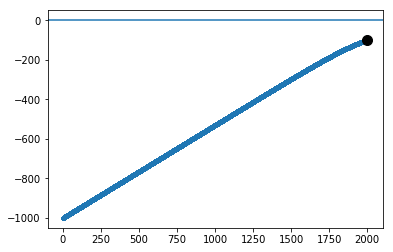

64.84130859375 64.852294921875 64.86328125


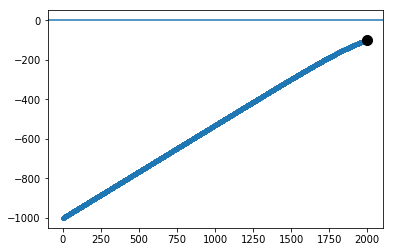

64.852294921875 64.8577880859375 64.86328125


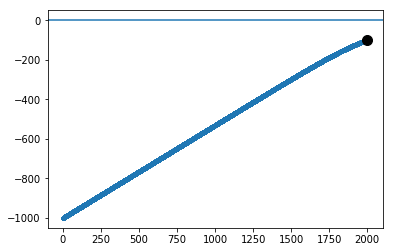

64.852294921875 64.85504150390625 64.8577880859375


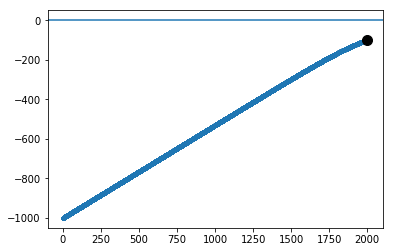

Initial Angle Downhole:  64.85504150390625  Final Angle in Ice:  75.39693227011824
Horizontal Distance at End:  6560.601646818453  ft.
Horizontal Distance at End:  1988.0611050965013  m
Depth at End:  -327.9866123638681 ft.
Time Of Flight Under Ice:  12933.359919981034  ns
Length of Path Under Ice:  7198.491359996927  ft.


In [19]:
#find the ray that connects the Tx and Rx, try first using "normal" refracting propagation.  Note that 
#in principle there could be 2 solutions, but this code right now only finds the first one, starting 
#from zenith down
#this code definitely works for two things below the ice, and may also work (I think it does but can't promise)
#for a tx or rx above the surface (but not both)

#the inputs:
southPoleFlag=1; #1 for South Pole, 0 for Greenland, 2 for changeable model for testing
depthRxm=[100] #depth in m of rx, positive number is below surface
surfaceTxm=[2000] #distance across surface between tx and rx in m
depthTxm=[1000] #depth in m of tx, negative number for above-surface pulser, positive for below surface

for k in range(0,len(depthRxm)): #swap tx and rx if needed so code doesn't break if Tx/Rx swapped
    if depthRxm[k]<depthTxm[k]:
        depthTxm1=depthTxm[k]
        depthTxm[k]=depthRxm[k]
        depthRxm[k]=depthTxm1

depthRx=np.zeros(len(depthRxm))
depthTx=np.zeros(len(depthTxm))
surfaceTx=np.zeros(len(surfaceTxm))

'''
   surface Tx
------------------
|                |
| depth          | depth Tx
|   Rx
|
'''

#convert to feet
for k in range(0,len(depthRxm)):
    depthRx[k]=depthRxm[k]*3.28
    surfaceTx[k]=surfaceTxm[k]*3.28
    depthTx[k]=depthTxm[k]*3.28

#iterate to propagate the ray
stepSize=5 #in feet
totalPathAll=[]
timeOfFlightAll=[]
initialAngleAll=[]
normalFlagAll=[]
timeOfFlightDirAll=[] #direct straight line ray
totalPathDirAll=[] #direct straight line ray

for k in range(0,len(depthRx)):
    #find direct straight line ray
    
    normalRayFlag=0 #is it a normal ray, start this flag at 0.
    print("****Trying Normal Ray Tracing...")
    end = 90.0
    start = 0.0
    numSteps = 50000 # number of rays to estimate - larger is more accurate
    stepSize = (surfaceTx[k] + abs(depthRx[k] - depthTx[k])) / numSteps # triangle inequality
    
    print("Step size:", stepSize)
    while (end - start > 0.005 and start < end): 
        j = (end + start) / 2.0
 
        print(start,j,end)
        
        # code
        # ===============================================
        timeOfFlight=0
        totalPath=0
        angle1=j*np.pi/180 #defined from zenith down, valid to 90 degrees
        locationOfRayEnd=(0,-1*depthRx[k]) #start at the antenna down the hole
        rayCoordH=[] # x coordinates of path
        rayCoordV=[] # y coordinates of path
        rayCoordH.append(locationOfRayEnd[0]*0.3048) # in m
        rayCoordV.append(locationOfRayEnd[1]*0.3048) # in m
        
        x = 1
        
        for i in range (0,numSteps*2): # numSteps is upper bound by triangle inequality
            # n1
            if(locationOfRayEnd[1] >= 0):
                index1=1
            else:
                index1 = getIndex(getDensity(-1*locationOfRayEnd[1]))
            
            # add new coordinates of step
            locationOfRayEnd = (locationOfRayEnd[0]+ np.sin(angle1)*stepSize,
                                locationOfRayEnd[1]+ x*np.cos(angle1)*stepSize)
            rayCoordH.append(locationOfRayEnd[0]*0.3048)
            rayCoordV.append(locationOfRayEnd[1]*0.3048)
            
            # n2
            if(locationOfRayEnd[1] >= 0):
                index2=1
            else:
                index2=getIndex(getDensity(-1*locationOfRayEnd[1]))
            #print(index2/index1)
            
            # theta 2
            angle2 = refractRay(index1,index2,angle1)
            

            
            #print(i, index1,index2,locationOfRayEnd,angle1*180/np.pi,angle2*180/np.pi)
            
            if (np.isnan(angle2) or                       
                locationOfRayEnd[1] >= -1*depthTx[k]):# or   # went higher than Tx
                #locationOfRayEnd[1] >= 0):                # breached surface
                #print("Stopped at step", i)
                break # break out of for loop [i]
                
           # if (locationOfRayEnd[0] >= surfaceTx[k]+10):
           #     break
            
            if(angle2 > 89.9*np.pi/180):
                break
                #x = -1
                
                
            # reset theta1 to theta2
            angle1 = angle2

            # update total path length in ft. and time of flight in ns
            totalPath=totalPath+stepSize #total path in ice
            timeOfFlight=timeOfFlight+stepSize*index1*0.3048/3e8*1e9 #in ns
            
        # ========================================
        
        plt.figure(1)
        ax= plt.subplot(111)
        #plt.axis('scaled')

        #ax.set_ylim(ymin=-501, ymax=-500)
        #ax.set_xlim(xmin=980, xmax=1000)

        plt.plot(rayCoordH,rayCoordV, linestyle="None", marker='.')
        plt.plot(surfaceTxm[0], -1*depthTxm[0], marker='o', markersize=10, color="black")
        plt.axhline(y=0)

        plt.show()

        if (locationOfRayEnd[0] > surfaceTx[k]):  #??
            end = j
            # rerun loop
        else:
            start = j
            # rerun loop
 
    if (locationOfRayEnd[1]>=-1.*depthTx[k]-5 and locationOfRayEnd[1]<-1.*depthTx[k]+5):
        normalRayFlag=1
        #print("Ray Tracer Converged, Normal Mode")
        print("Initial Angle Downhole: ", j, " Final Angle in Ice: ", angle1*180/np.pi)
        print("Horizontal Distance at End: ", locationOfRayEnd[0], " ft.")
        print("Horizontal Distance at End: ", locationOfRayEnd[0]/3.3, " m")

        print("Depth at End: ",locationOfRayEnd[1],"ft.")
        print("Time Of Flight Under Ice: ", timeOfFlight, " ns")
        print("Length of Path Under Ice: ", totalPath, " ft.")
    else:
        print("****Ray Tracer Did Not Converge with Normal Mode, there is no solution")
    
    totalPathAll.append(totalPath)
    timeOfFlightAll.append(timeOfFlight)
    normalFlagAll.append(normalRayFlag)
    initialAngleAll.append(j)

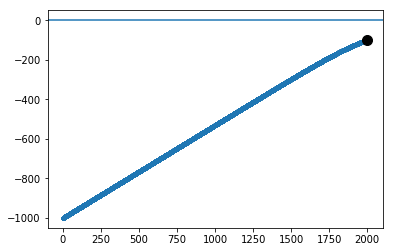

In [20]:
#plot ray
plt.figure(1)
ax= plt.subplot(111)
#plt.axis('scaled')

#ax.set_ylim(ymin=-300, ymax=0)
#ax.set_xlim(xmin=980, xmax=1000)

plt.plot(rayCoordH,rayCoordV, linestyle="None", marker='.')
plt.plot(surfaceTxm[0], -1*depthTxm[0], marker='o', markersize=10, color="black")
plt.axhline(y=0)

plt.show()